<a href="https://colab.research.google.com/github/MogY23/HSE_project_credit_scoring_23/blob/main/CS_ver_of_MY_new3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Решение задачи расчета кредитного скоринга

* Загрузка данных и их анализ
* Обучение и оценка качества модели
  + обучение модели
  + оценка качества модели
* Интерпретация результатов модели
* Сохранение результатов

Используем следующие библиотеки Python:

*   Pandas - библиотеки для работы с таблицами
*   Numpy - библиотеки для быстрых и эффективных вычислений
*   Matplotlib - для визуализации данных
*   Sklearn - библиотеки с основными инструментами ML


Задача состоит в том, чтобы по различным характеристикам клиентов спрогнозировать целевую переменную - имел клиент просрочку 90 и более дней или нет (и если имел, то банк не будет выдавать кредит этому клиенту, а иначе будет).

## <font color='green'>1. Загрузка данных и их первичный анализ</font>

In [272]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression  #логистическая регрессия для задач бинарной классификации (уйдет/не уйдет)

import warnings
warnings.filterwarnings("ignore")

Подключаемся к БД и загружаем данные

In [273]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2023-05-30 10:32:46--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2023-05-30 10:32:47 (626 MB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



In [274]:
!sudo apt update && sudo apt install --yes python3 python3-pip && \ #загрузка вспомогательных ячеек для работы с БД (обновляем библиотеки)
!pip3 install psycopg2-binary

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `sudo apt update && sudo apt install --yes python3 python3-pip && \ #загрузка вспомогательных ячеек для работы с БД (обновляем библиотеки)'
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [275]:
import psycopg2 #подключение к БД
#параметры для подключения прописаны в БД заранее
conn = psycopg2.connect("""  
    host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
    port=6432
    sslmode=verify-full
    dbname=db_clients
    user=mlhs_student
    password=mlhs_student
    target_session_attrs=read-write
""") 

In [277]:
query = "SELECT * from public.credit_scoring"

data = pd.read_sql_query(query, conn) #записываем из базы нужную таблицу к себе в объект data 

conn.close() #отключаемся от базы

InterfaceError: ignored

Описание данных клиентов:
* Целевая переменная **SeriousDlqin2yrs**: Клиент имел просрочку 90 и более дней
* RevolvingUtilizationOfUnsecuredLines: Общий баланс средств (total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits). 
* age: Возраст заемщика 
* NumberOfTime30-59DaysPastDueNotWorse: Сколько раз за последние 2 года наблюдалась просрочка 30-59 дней. 
* DebtRatio: Ежемесячные расходы (платеж по долгам, алиментам, расходы на проживания) деленные на месячный доход. 
* MonthlyIncome: Ежемесячный доход. 
* NumberOfOpenCreditLinesAndLoans: Количество открытых кредитов (напрмер, автокредит или ипотека) и кредитных карт. 
* NumberOfTimes90DaysLate: Сколько раз наблюдалась просрочка (90 и более дней)
* NumberOfTime60-89DaysPastDueNotWorse: Сколько раз за последние 2 года заемщик задержал платеж на 60-89 дней.
* NumberOfDependents: Количество иждивенцев на попечении (супруги, дети и др). 
* RealEstateLoansOrLines: Закодированное количество кредиов (в том числе под залог жилья) - чем больше код буквы, тем больше кредитов 
* GroupAge: закодированная возрастная группа - чем больше код, тем больше возраст.




In [296]:
data=data.drop_duplicates() #сразу убираем дубликаты
data.head(20) # голова таблицы, первые 5 строчек по умолчанию или сколько нужно, если укажешь в скобках

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,RealEstateLoansOrLines,GroupAge
0,0,0.221813,0,0.527888,3280.0,7,0,0,2.0,1,c
1,0,0.602794,0,0.065868,333.0,2,0,0,0.0,1,b
2,1,0.025656,0,0.475841,3000.0,7,0,0,2.0,1,c
3,0,0.075427,0,0.085512,7916.0,6,0,0,0.0,1,b
4,0,0.046560,0,0.241622,2416.0,9,0,0,0.0,1,d
5,1,0.392248,0,1.595253,4676.0,14,0,0,1.0,2,d
6,0,0.034421,0,0.042383,2500.0,17,0,0,1.0,1,e
7,0,0.392995,2,0.436103,5500.0,15,0,0,0.0,1,d
8,1,0.695321,0,0.618575,7859.0,8,0,0,3.0,1,c
9,0,0.055950,0,0.052868,2666.0,7,0,0,0.0,1,d


RealEstateLoansOrLines - закодированное кол-во кредитов. Чем больше код буквы, тем больше кредитов. Тк показатель количественный, попробуем его перевести в числовой вид

In [279]:
data = data.replace('A', '1')
data = data.replace('B', '2')
data = data.replace('C', '3')
data = data.replace('D', '4')
data = data.replace('E', '5')
data['RealEstateLoansOrLines']=pd.to_numeric(data['RealEstateLoansOrLines']) #меняем тип столбца

Проверяем

In [234]:
data.tail() #конец таблицы, последние 5 строчек по умолчанию или сколько нужно, если укажешь в скобках

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfDependents,RealEstateLoansOrLines,GroupAge
149995,0,0.977899,63.0,0,517.000000,5400.0,5,0.0,1,d
149996,0,0.025449,58.0,0,0.253855,15500.0,7,2.0,1,d
149997,0,0.058001,83.0,0,0.013997,5000.0,6,0.0,1,e
149998,0,0.071273,42.0,0,0.008638,6945.0,3,1.0,1,c
149999,0,1.026395,44.0,0,0.494819,5500.0,7,1.0,1,c


In [212]:
data.info() #детальная информация по данным

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149366 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      149366 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  149366 non-null  float64
 2   age                                   134633 non-null  float64
 3   NumberOfTime30-59DaysPastDueNotWorse  149366 non-null  int64  
 4   DebtRatio                             149366 non-null  float64
 5   MonthlyIncome                         120171 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       149366 non-null  int64  
 7   NumberOfTimes90DaysLate               149366 non-null  int64  
 8   NumberOfTime60-89DaysPastDueNotWorse  149366 non-null  int64  
 9   NumberOfDependents                    145542 non-null  float64
 10  RealEstateLoansOrLines                149366 non-null  int64  
 11  

11 признаков + целевая переменная

# Разведочный анализ данных

## 1. Оценка качества данных
Посмотрим, есть ли в данных пропущенные значения.

In [280]:
data.isna().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                     14733
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29195
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3824
RealEstateLoansOrLines                      0
GroupAge                                    0
dtype: int64

Не хватает данных по возрасту клиентов, ежемесячному доходу и кол-ву иждивенцев.

### Обработка пропущенных значений


  

*   NumberOfDependents - **числовой признак**. Количество иждивенцев на попечении (супруги, дети и др). 




In [281]:
data.NumberOfDependents.value_counts(dropna=False)

0.0     86370
1.0     26314
2.0     19522
3.0      9483
NaN      3824
4.0      2862
5.0       746
6.0       158
7.0        51
8.0        24
10.0        5
9.0         5
13.0        1
20.0        1
Name: NumberOfDependents, dtype: int64

Пропусков **2,6%**. Можно заполнить наиболее частым значением: 0.

In [287]:
data['NumberOfDependents'] = data['NumberOfDependents'].fillna(0) #строки с пропусками заполняем 0

 

*   Age - числовой признак. Возраст заемщика.Пропущено **9,86%** данных. Убираем, будем опираться на возрастные групп

In [288]:
data = data.drop(['age'], axis=1)


*   MonthlyIncome - **числовой признак**. Ежемесячный доход. Пропущено 19,82% данных. Визуализируем содержание столбца

{'whiskers': [<matplotlib.lines.Line2D at 0x7fc94c86a380>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc94c971120>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc945b9feb0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc94c970970>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc94c973940>],
 'means': []}

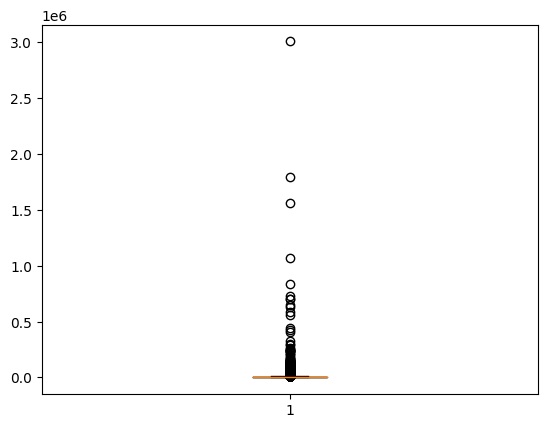

In [289]:
sr=data[data['MonthlyIncome']>0] #исключаем пустые, они помешают построить график
plt.boxplot(sr.MonthlyIncome)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fc945bb9c90>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc945bb8400>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc945bba3e0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc945bbbb80>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc945cbac20>],
 'means': []}

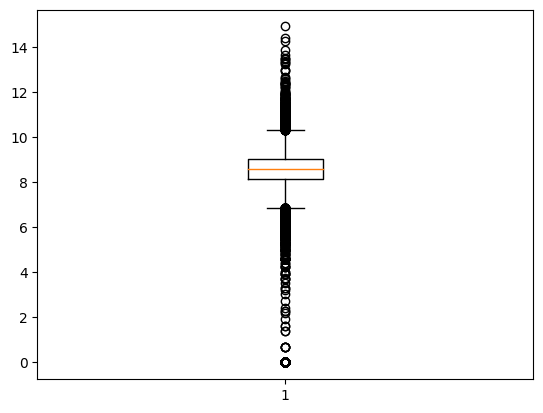

In [290]:
sr=data[data['MonthlyIncome']>0] #исключаем пустые, они помешают построить график
plt.boxplot(np.log(sr.MonthlyIncome))


Большинство данных лежат в пределах 1млн руб. Посчитаем медиану

In [291]:
median =  data['MonthlyIncome'].median()
print(median)

5400.0


Данным значением заполним пустые строки

In [292]:
data['MonthlyIncome'].fillna(median, inplace=True)

Проверяем все ли данные были исправлены

In [293]:
data.isna().sum()

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
RealEstateLoansOrLines                  0
GroupAge                                0
dtype: int64

## Сохранение данных

In [294]:
data.to_csv("credit_scoring_output.csv", index=False) #сохраняем табличку к себе

## Основные числовые характеристики

Смотрим, что из себя представляют данные

In [295]:
data.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,RealEstateLoansOrLines
count,148772.000000,148772.000000,148772.000000,148772.000000,1.487720e+05,148772.000000,148772.000000,148772.000000,148772.000000,148772.000000
mean,0.067183,6.095781,0.397037,355.330259,6.430229e+03,8.492680,0.240932,0.215235,0.743177,1.077535
std,0.250340,250.783481,3.885603,2045.141774,1.294077e+04,5.136691,3.859104,3.843567,1.109608,0.307209
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.030550,0.000000,0.178469,3.900000e+03,5.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.155550,0.000000,0.368514,5.400000e+03,8.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.558118,0.000000,0.871654,7.416000e+03,11.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,50708.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,98.000000,20.000000,5.000000


In [297]:
corr = data.corr() # строим матрицу корреляций

corr.style.background_gradient(cmap='coolwarm')

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,RealEstateLoansOrLines
SeriousDlqin2yrs,1.000000,-0.001852,0.129026,-0.008155,-0.017545,-0.031492,0.118914,0.100498,0.046208,0.027451
RevolvingUtilizationOfUnsecuredLines,-0.001852,1.000000,-0.001283,0.003914,0.006475,-0.011768,-0.000958,-0.000941,0.000982,-0.000960
NumberOfTime30-59DaysPastDueNotWorse,0.129026,-0.001283,1.000000,-0.005151,-0.008337,-0.040203,0.974902,0.980084,0.005761,-0.001703
DebtRatio,-0.008155,0.003914,-0.005151,1.000000,-0.018272,0.047372,-0.007241,-0.006266,-0.046061,0.085988
MonthlyIncome,-0.017545,0.006475,-0.008337,-0.018272,1.000000,0.085772,-0.010926,-0.009377,0.065391,0.083710
NumberOfOpenCreditLinesAndLoans,-0.031492,-0.011768,-0.040203,0.047372,0.085772,1.000000,-0.070220,-0.059117,0.064797,0.262058
NumberOfTimes90DaysLate,0.118914,-0.000958,0.974902,-0.007241,-0.010926,-0.070220,1.000000,0.988908,-0.002903,-0.011557
NumberOfTime60-89DaysPastDueNotWorse,0.100498,-0.000941,0.980084,-0.006266,-0.009377,-0.059117,0.988908,1.000000,-0.003754,-0.009141
NumberOfDependents,0.046208,0.000982,0.005761,-0.046061,0.065391,0.064797,-0.002903,-0.003754,1.000000,0.047532
RealEstateLoansOrLines,0.027451,-0.000960,-0.001703,0.085988,0.083710,0.262058,-0.011557,-0.009141,0.047532,1.000000


Очень большая корреляция между сроками просрочки. Необходимо удалить 2 лишних 

In [298]:
data = data.drop(['NumberOfTimes90DaysLate','NumberOfTime60-89DaysPastDueNotWorse'],axis=1)

In [230]:
for col in data.columns:
    try:
        print(col, np.corrcoef(data[col], data['SeriousDlqin2yrs'])[0][1])
    except:
        pass

SeriousDlqin2yrs 1.0
RevolvingUtilizationOfUnsecuredLines -0.0018373288966951223
age -0.10018008617697793
NumberOfTime30-59DaysPastDueNotWorse 0.13117433182769575
DebtRatio -0.008094789937671423
MonthlyIncome -0.017395964693790532
NumberOfOpenCreditLinesAndLoans -0.031443282135977184
NumberOfDependents 0.046168596434580336
RealEstateLoansOrLines 0.027447465425237388


Логично, что больше всего с показателем просрочки 90+ коррелируют возраст клиента и наличие просрочек ранее.

## <font color='green'>2.1. Обучение модели</font>



Сформируем матрицу X объект-признак и вектор y целевой переменной.

In [299]:
X_full = data.drop('SeriousDlqin2yrs', axis=1) # матрица объект-признак
y = data['SeriousDlqin2yrs'] # целевая переменная

In [300]:
X = X_full.drop(['GroupAge'], axis=1)

Давайте применим логистическую регрессию для поиска клиентов с просрочками 90+

Данные разбиваем на train и test (test — 25% от всех данных).

In [301]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

Для линейных моделей очень важно масштабирование признаков. У нас часть данных представлена десятками, а часть тысячами и тд, это негативно влияет на модель. Для привидения к одному масштабу используем StandardScaler, обучив метод на тренировочных данных и применив его и к трейну, и к тесту.

In [302]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(Xtrain)

Xtrain = pd.DataFrame(ss.transform(Xtrain), columns=X.columns)
Xtest = pd.DataFrame(ss.transform(Xtest), columns=X.columns)

Xtrain.head()

,RevolvingUtilizationOfUnsecuredLines,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfDependents,RealEstateLoansOrLines
0,-0.022884,-0.105443,-0.174431,-0.075579,-0.493444,-0.673634,-0.253086
1,-0.023341,-0.105443,-0.174195,0.112095,0.678122,-0.673634,6.227410
2,-0.023121,-0.105443,-0.174668,-0.335435,-0.688705,-0.673634,-0.253086
3,-0.022423,-0.105443,-0.174328,-0.282453,0.287600,-0.673634,-0.253086
4,-0.023349,-0.105443,-0.174565,0.063733,-0.298183,-0.673634,-0.253086


Обучим логистическую регрессию на train и сделаем предсказание на новых для нее данных (test).

In [303]:
from sklearn.linear_model import LogisticRegression # линейная модель для задачи классификации

model = LogisticRegression() # объявление модели

model.fit(Xtrain, ytrain) # обучение модели

LogisticRegression()

In [304]:
pred_test = model.predict(Xtest) # предсказание классов

In [305]:
accuracy_score(ytest, pred_test) #доля верных ответов на тестовой выборке

0.9324492557510149

Проверим, сбалансирована ли выборка.

In [306]:
y.value_counts()

0    137857
1      9941
Name: SeriousDlqin2yrs, dtype: int64

Баланса классов нет: большинство клиентов не имеют просрочек ($y=0$). Если я "в лоб" проставлю всем константу 0, то угадаю 138571 из 148552 (это как раз 93,3%).

## <font color='green'>2.2. Валидация модели</font>

Для оценки качества модели используются различные метрики качества. Построим матрицу ошибок
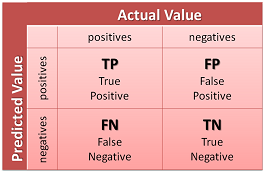


In [307]:
from sklearn.metrics import confusion_matrix

confusion_matrix(ytest, pred_test)

array([[34434,    21],
       [ 2475,    20]])



Также можно посмотреть на метрику **recall (полнота)** - она показывает, какую долю клиентов с просрочками 90+ дней (объектов положительного класса) определила модель.(TN/(FN+TN))</font>

In [308]:
from sklearn.metrics import recall_score

recall_score(ytest, pred_test)

0.008016032064128256

Пропустили 98,6% клиентов, которые с просрочками 90+ дней.

Посмотрим precision (**точность**) - показывает сколько клиентов, определенных, как "имеют просрочки 90+", действительно являются таковыми (TN/(FP+TN)

In [309]:
from sklearn.metrics import precision_score #точность. Из определенных, как "имеют просрочки 90+" сколько действительно имеют её(TN/(FP+TN)

precision_score(ytest, pred_test)

0.4878048780487805

С одной стороны recall очень мал, следовательно, мы выдадим много невозвратных кредитов. Но в данном случае нам гораздо важнее precision_score, тк банк зарабатывает на кредитах и любой ложный отказ это упущенная выгода, а просрочки Банк взымает в судебном порядке .


<font color='blue'>Попробуем изменить **порог для перевода вероятности в классы** со стандартного 0.5 на порог поменьше.</blue>

In [310]:
probs = model.predict_proba(Xtest)

probs[:10]

array([[0.95098313, 0.04901687],
       [0.93576239, 0.06423761],
       [0.96330953, 0.03669047],
       [0.93586922, 0.06413078],
       [0.99696819, 0.00303181],
       [0.94458559, 0.05541441],
       [0.92199358, 0.07800642],
       [0.94197031, 0.05802969],
       [0.94353699, 0.05646301],
       [0.96158969, 0.03841031]])

In [331]:
probs_arrears = probs[:,1]

classes = probs_arrears > 0.7 #по умолчанию 0,5 было

In [332]:
confusion_matrix(ytest, classes)

array([[34435,    20],
       [ 2475,    20]])

In [333]:
recall_score(ytest, classes)

0.008016032064128256

In [334]:
from sklearn.metrics import precision_score #точность. Из определенных, как "имеют просрочки 90+" сколько действительно имеют её(TN/(FP+TN)

precision_score(ytest, classes)

0.5

Незначительный рост recall и precision.

## <font color='green'>3. Интерпретация модели</font>

После обучения модели можно посмотреть на её веса, то есть на коэффициенты при признаках, найденные моделью.

In [335]:
model.coef_, model.intercept_

(array([[-0.01991069,  0.50509944, -0.09568222, -0.84140722, -0.12066997,
          0.19851213,  0.17455148]]),
 array([-2.69866445]))

In [336]:
import pandas as pd

coef_table = pd.DataFrame({'features' : list(X.columns), 'weights' : list(model.coef_[0])})

coef_table.sort_values(by='weights')

,features,weights
3,MonthlyIncome,-0.841407
4,NumberOfOpenCreditLinesAndLoans,-0.120670
2,DebtRatio,-0.095682
0,RevolvingUtilizationOfUnsecuredLines,-0.019911
6,RealEstateLoansOrLines,0.174551
5,NumberOfDependents,0.198512
1,NumberOfTime30-59DaysPastDueNotWorse,0.505099


Если вес у признака положительный, то признак вносит положительный вклад в ответ, то есть чем больше значение признака, тем больше это дает вклад в положительный класс объекта и наоборот.

*Пример:* 

чем **выше** ежемесячный доход, тем **меньше** вероятность просрочки 90+, 

но чем **больше** просрочек за 2 года, тем **больше** верочтность просрочки 90+

## <font color='green'>4. Сохранение результатов экспериментов</font>

Что сохраняем?

* Предсказания модели
* Эксперименты
* Модель

Сначала сохраним предсказания модели в файл:

In [253]:
Xtest['predictions'] = probs_arrears

Xtest[['predictions']].to_csv("PredictionsArrears.csv", index=False)

In [254]:
Xtest.head().T

,0,1,2,3,4
RevolvingUtilizationOfUnsecuredLines,-0.026379,-0.026925,-0.027331,-0.025067,-0.026451
age,1.244364,0.451367,0.781783,1.574779,-1.134625
NumberOfTime30-59DaysPastDueNotWorse,-0.101886,-0.101886,-0.101886,0.152633,-0.101886
DebtRatio,-0.161079,-0.160993,-0.161072,1.532148,-0.161148
MonthlyIncome,0.022723,-0.201476,0.832999,-0.077339,-0.013390
NumberOfOpenCreditLinesAndLoans,0.683813,1.073176,-0.094913,0.294450,0.294450
NumberOfDependents,2.033721,-0.669141,-0.669141,-0.669141,1.132767
RealEstateLoansOrLines,-0.253626,-0.253626,-0.253626,2.993950,-0.253626
predictions,0.047812,0.047907,0.025854,0.046700,0.095484


Теперь сохраним модель:

In [255]:
import pickle 

with open('model.pickle', 'wb') as f:
    pickle.dump(model, f)

# а так модель можно загрузить из файла:  
# with open('filename.pickle', 'rb') as f:
#     model = pickle.load(f)

Сохраним полученную модель, файл с предсказаниями и ноутбук с экспериментами на гитхаб.

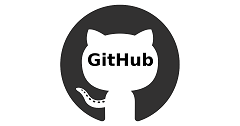

## <font color='green'>5. Градиентный бустинг</font>

Мы поработали с линейными моделями. Они весьма и весьма простые — предполагают независимость признаков и линейную связь между каждым признаком и целевой переменной. Конечно, в наших данных вряд ли всё так просто. Можно пытаться усложнять линейные модели: добавлять нелинейные признаки, переходить в новое признаковое пространство. Но это всё полумеры.

Сейчас мы поработаем с градиентным бустингом — одним из самых мощных подходов для работы с табличными данными.

Пока не ушли далеко — посчитаем и запомним качество логистической регрессии.

In [337]:
from sklearn import metrics

print("LR quality:")
print("precision: ", metrics.precision_score(ytest, classes))
print("recall: ", metrics.recall_score(ytest, classes))
print("auc-roc: ", metrics.roc_auc_score(ytest, probs[:, 1]))

LR quality:
precision:  0.5
recall:  0.008016032064128256
auc-roc:  0.6832779650143416


Есть много имплементаций градиентного бустинга. Мы будем пользоваться CatBoost — библиотекой от Яндекса, которая очень эффективно написана и широко используется в мире.

In [339]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [340]:
from catboost import CatBoostClassifier, Pool

In [341]:
Xtest = Xtest.drop(['predictions'],axis=1)

KeyError: ignored

In [342]:
Xtrain.head().T

,0,1,2,3,4
RevolvingUtilizationOfUnsecuredLines,-0.022884,-0.023341,-0.023121,-0.022423,-0.023349
NumberOfTime30-59DaysPastDueNotWorse,-0.105443,-0.105443,-0.105443,-0.105443,-0.105443
DebtRatio,-0.174431,-0.174195,-0.174668,-0.174328,-0.174565
MonthlyIncome,-0.075579,0.112095,-0.335435,-0.282453,0.063733
NumberOfOpenCreditLinesAndLoans,-0.493444,0.678122,-0.688705,0.287600,-0.298183
NumberOfDependents,-0.673634,-0.673634,-0.673634,-0.673634,-0.673634
RealEstateLoansOrLines,-0.253086,6.227410,-0.253086,-0.253086,-0.253086


In [343]:
train_set = Pool(Xtrain, ytrain)
test_set = Pool(Xtest, ytest)

In [344]:
gbm = CatBoostClassifier(iterations=1500,#сколько деревьев строим
                          depth=2, #глубина 1го дерева
                          learning_rate=0.1,
                          loss_function='Logloss',
                          eval_metric='AUC',
                          verbose=False)
gbm.fit(train_set, eval_set=test_set)
gbm_preds = gbm.predict_proba(Xtest)

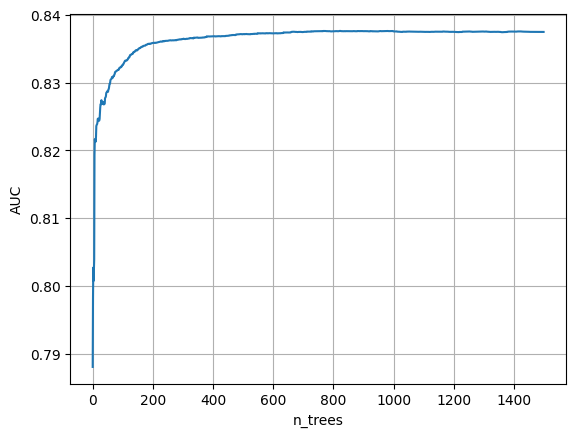

In [345]:
eval_metrics = gbm.get_evals_result()
plt.plot(eval_metrics['validation']['AUC'])
plt.xlabel('n_trees')
plt.ylabel('AUC')
plt.grid()

In [346]:
gbm_classes = (gbm_preds[:, 1] > 0.3)
print("precision: ", metrics.precision_score(ytest, gbm_classes))
print("recall: ", metrics.recall_score(ytest, gbm_classes))
print("auc-roc: ", metrics.roc_auc_score(ytest, gbm_preds[:, 1]))

precision:  0.40228502705953095
recall:  0.2681362725450902
auc-roc:  0.8376274708755778


In [349]:
coef_table = pd.DataFrame({'features' : list(X.columns), 'importances' : list(gbm.get_feature_importance())})

coef_table.sort_values(by='importances')

,features,importances
5,NumberOfDependents,1.291544
6,RealEstateLoansOrLines,1.756206
4,NumberOfOpenCreditLinesAndLoans,3.595112
3,MonthlyIncome,4.964778
2,DebtRatio,5.134086
1,NumberOfTime30-59DaysPastDueNotWorse,25.300277
0,RevolvingUtilizationOfUnsecuredLines,57.957996


## <font color='green'>6. Обработка категориальных признаков</font>

Выше мы удаляли все категориальные столбцы:

`X = X.drop(['GroupAge'], axis=1)`

А вдруг там содержится много полезной информации? Попробуем её сохранить.

In [350]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_full, y, test_size=0.25, random_state=42)

In [351]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical = ['GroupAge']
numeric_features = X.columns

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

X_transformed = column_transformer.fit_transform(Xtrain)
X_test_transformed = column_transformer.transform(Xtest)

In [352]:
X_transformed.shape

(110848, 11)

In [353]:
model = LogisticRegression()
model.fit(X_transformed, ytrain)
pred = model.predict_proba(X_test_transformed)

In [354]:
classes = (pred[:, 1] > 0.5)
print("precision: ", metrics.precision_score(ytest, classes))
print("recall: ", metrics.recall_score(ytest, classes))
print("auc-roc: ", metrics.roc_auc_score(ytest, pred[:, 1]))

precision:  0.5
recall:  0.008016032064128256
auc-roc:  0.6889564472145567


In [355]:
train_set = Pool(X_transformed, ytrain)
test_set = Pool(X_test_transformed, ytest)
gbm = CatBoostClassifier(iterations=100,
                          depth=2,
                          learning_rate=0.1,
                          loss_function='Logloss',
                          eval_metric='AUC',
                          verbose=False)
gbm.fit(train_set, eval_set=test_set)
gbm_preds = gbm.predict_proba(test_set)
gbm_classes = (gbm_preds[:, 1] > 0.3)
print("precision: ", metrics.precision_score(ytest, gbm_classes))
print("recall: ", metrics.recall_score(ytest, gbm_classes))
print("auc-roc: ", metrics.roc_auc_score(ytest, gbm_preds[:, 1]))

precision:  0.4175257731958763
recall:  0.2597194388777555
auc-roc:  0.8329460371912014
